# Ideal Parameter Analysis ($\delta=2$, $\tau=1.25$, $\alpha=2$) ($\delta$ slightly low)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2
expected_tau = 1.25
expected_alpha = 2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

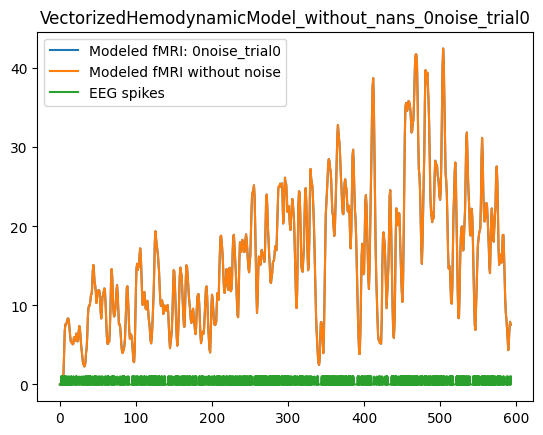

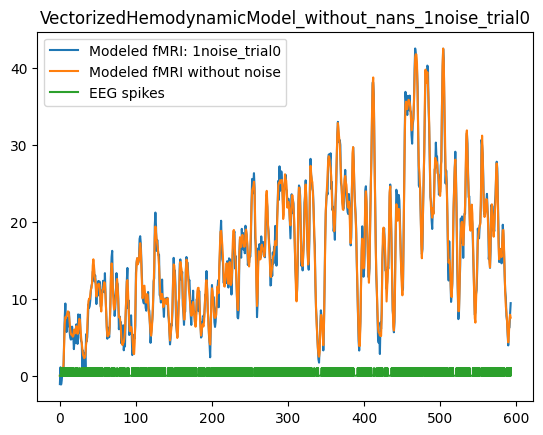

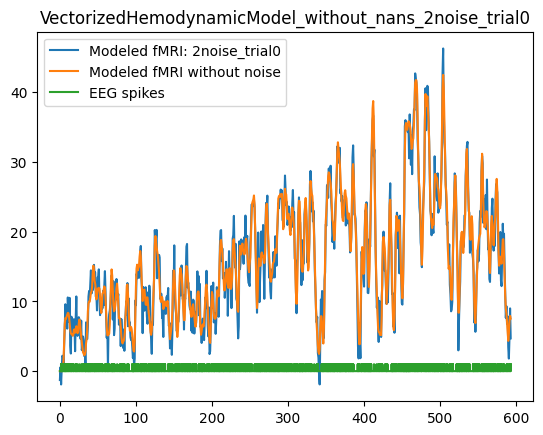

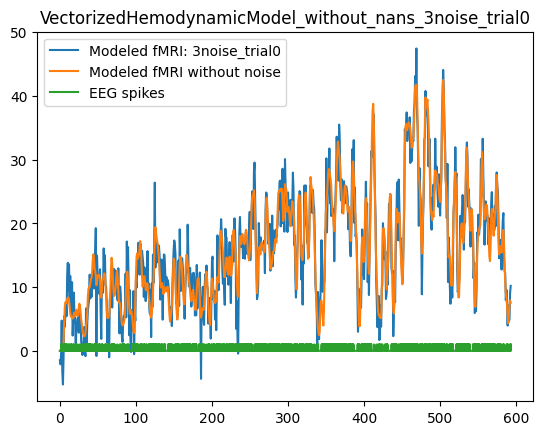

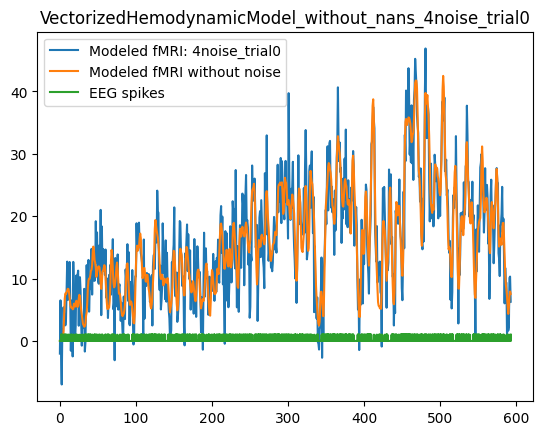

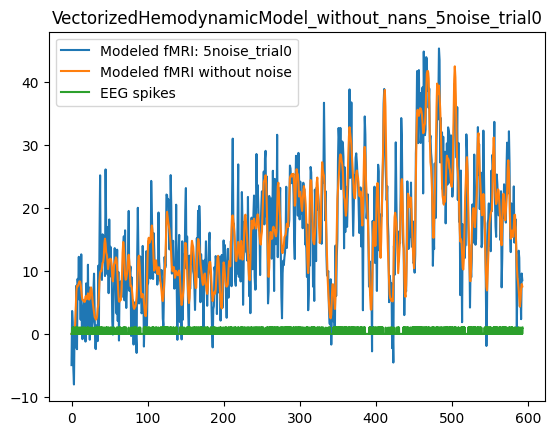

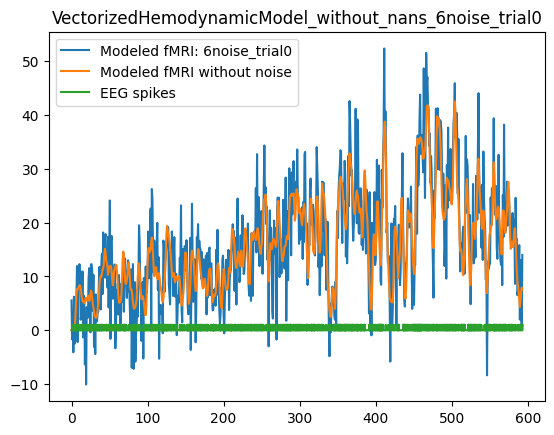

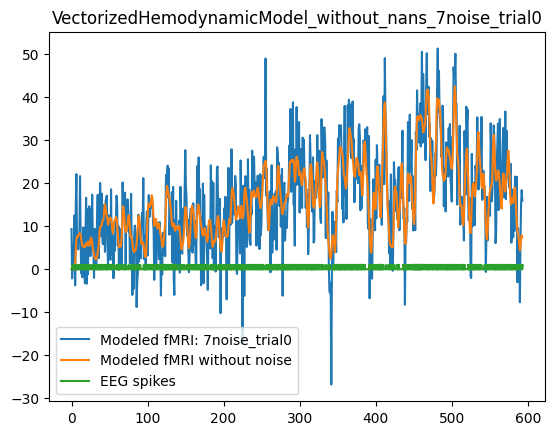

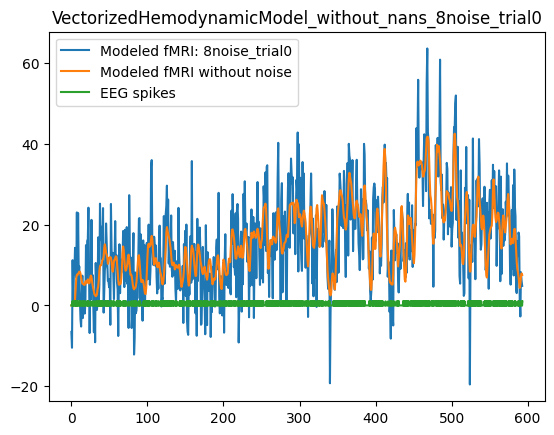

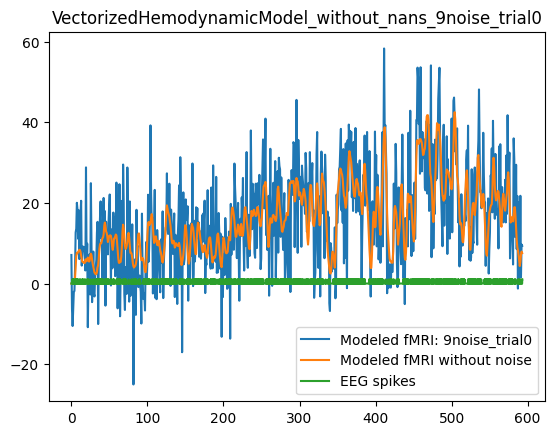

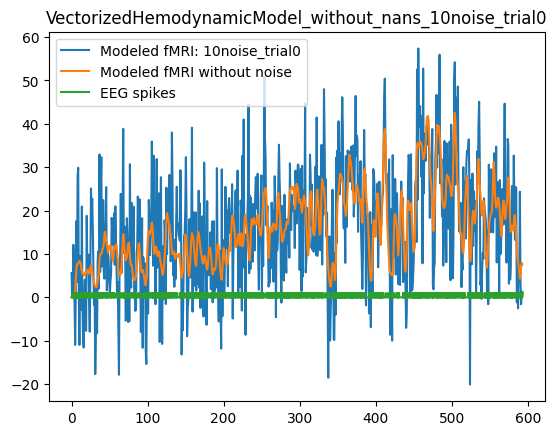

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2, tau=1.25, alpha=2


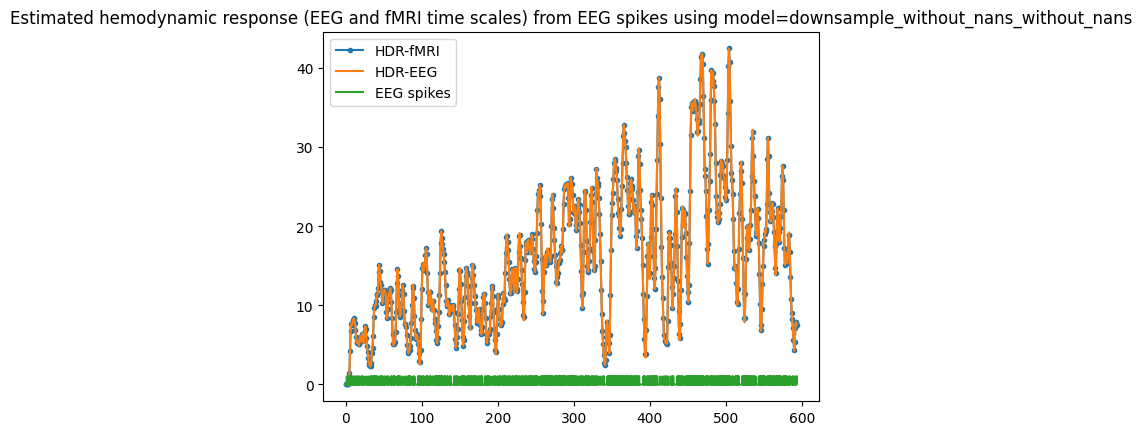

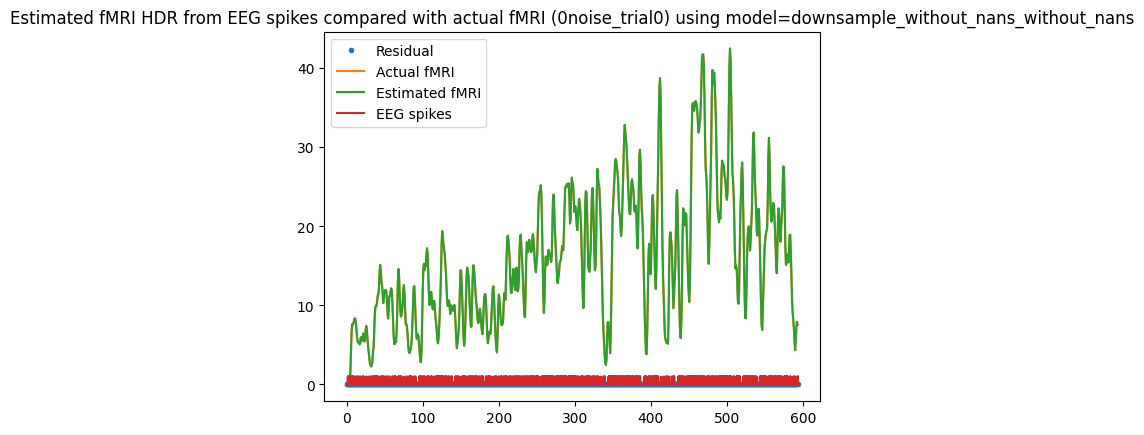

Residual Variance is 0.000000


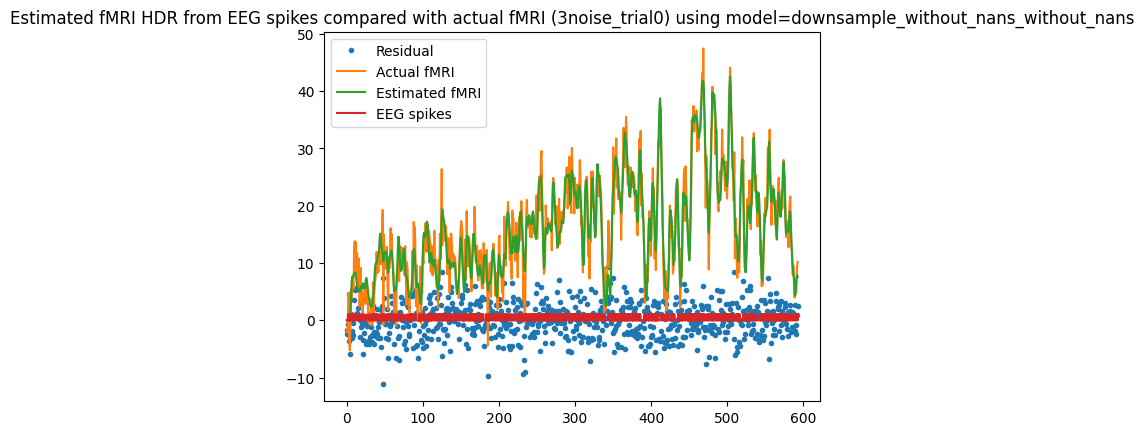

Residual Variance is 9.072142


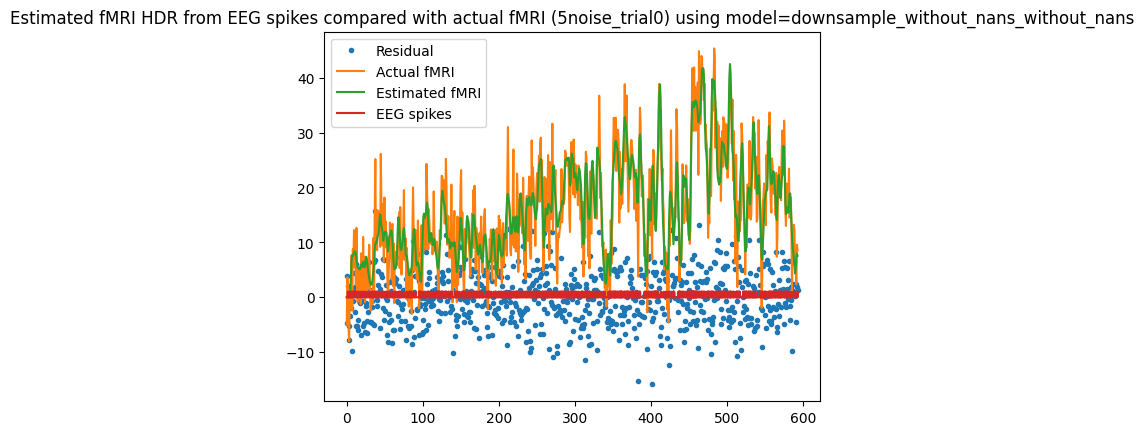

Residual Variance is 23.017667


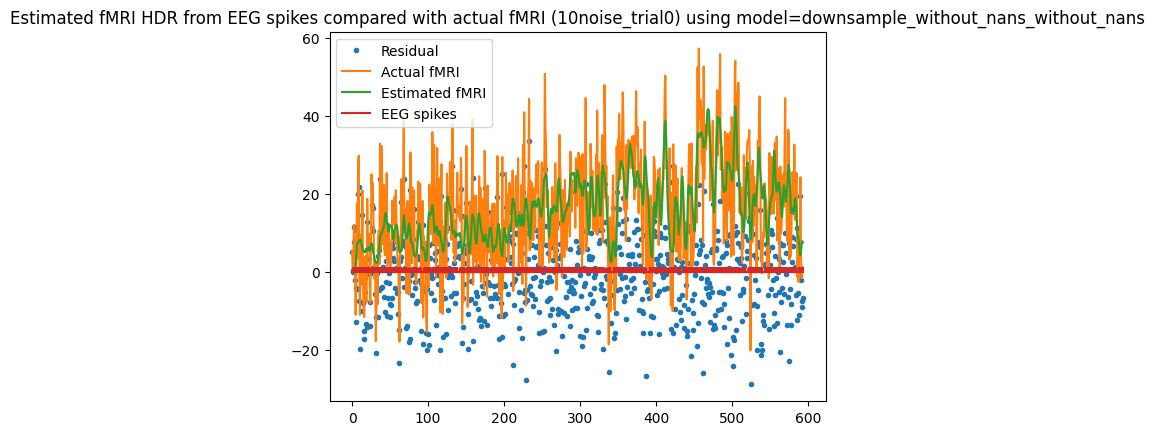

Residual Variance is 108.694757


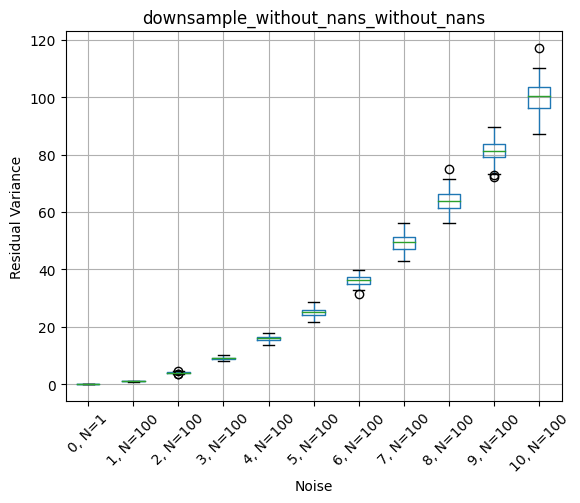

Scoring downsample_without_nans_with_nans delta=2, tau=1.25, alpha=2


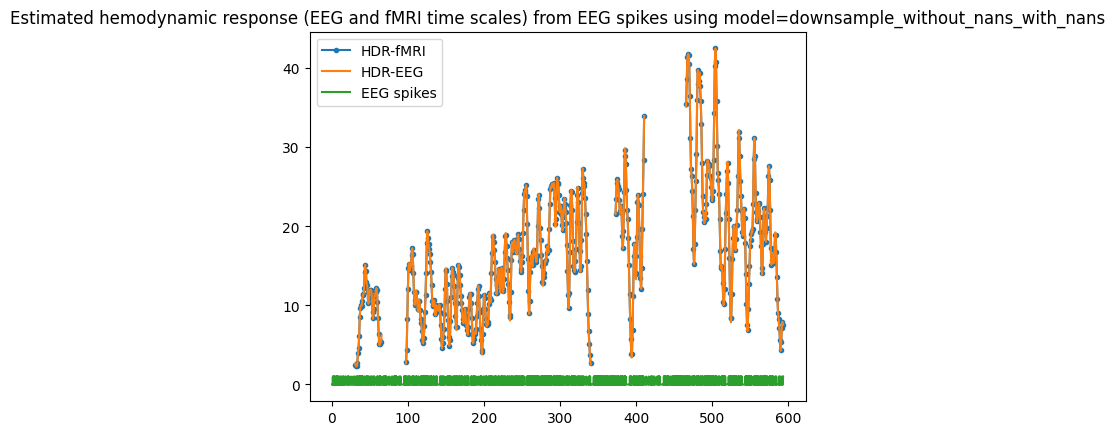

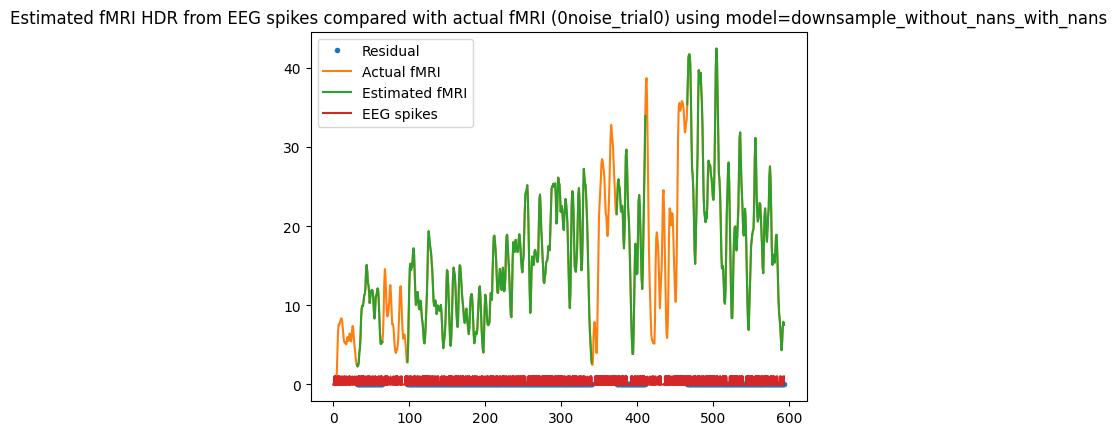

Residual Variance is 0.000000


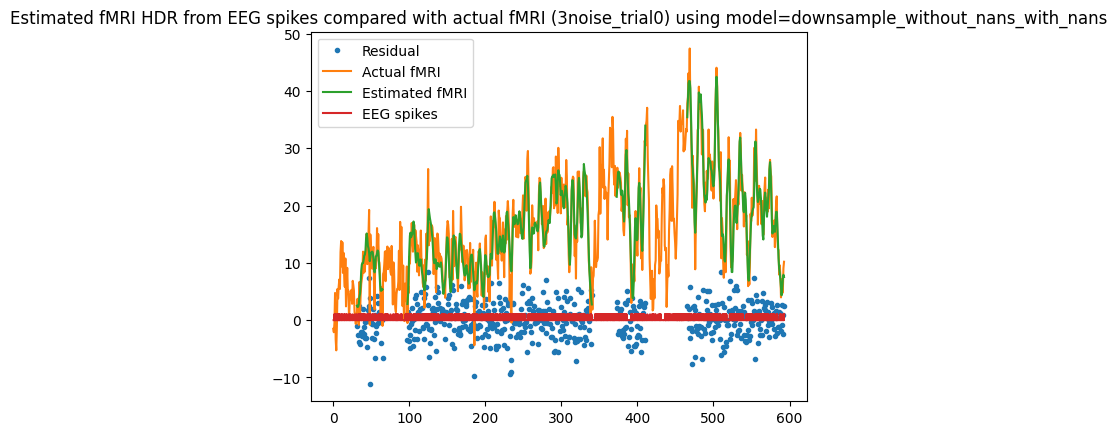

Residual Variance is 8.796241


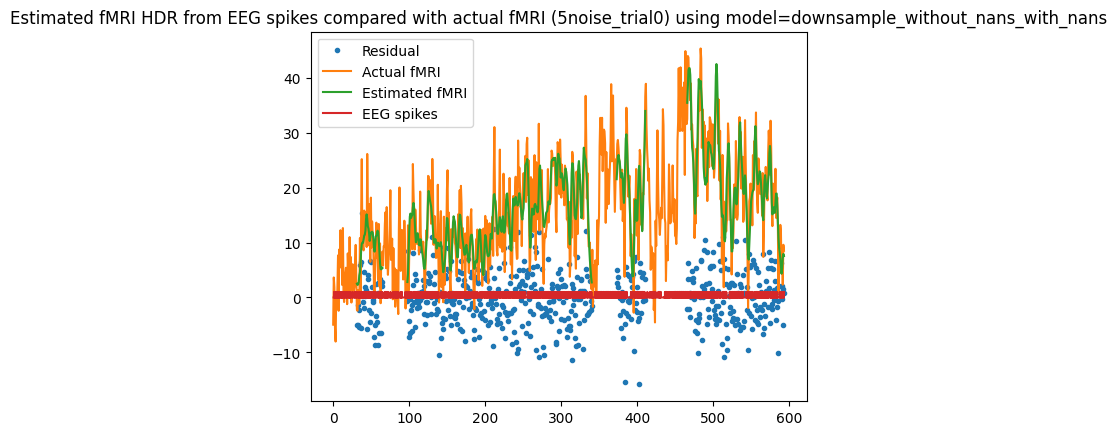

Residual Variance is 22.996312


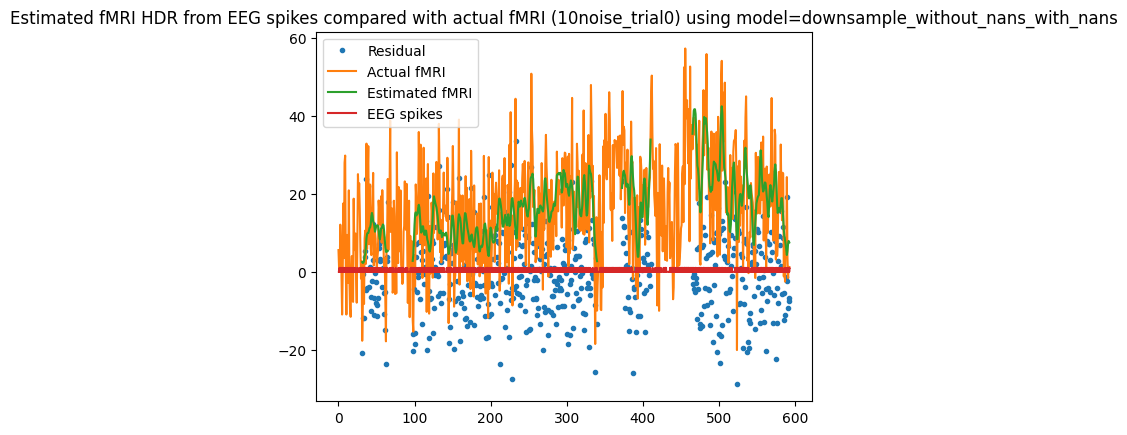

Residual Variance is 108.748525


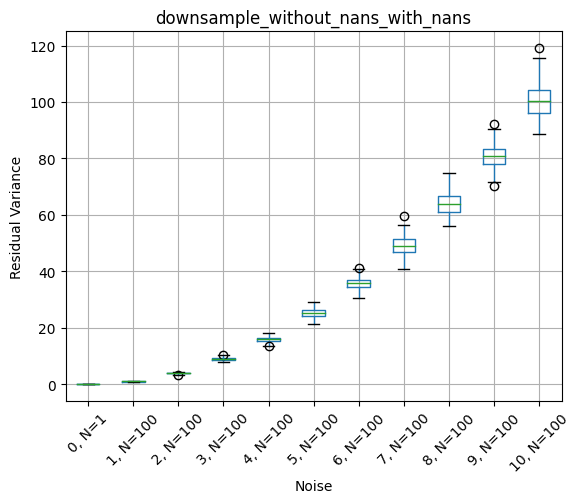

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   38.48114932293363   
1         downsample_without_nans_with_nans  35.358382356907896   
2      downsample_without_nans_without_nans  37.549877529497465   
3         downsample_without_nans_with_nans   34.54349332614063   
4      downsample_without_nans_without_nans  36.614292255739905   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  16.772254570217314   
18938  downsample_without_nans_without_nans  19.025675387188013   
18939     downsample_without_nans_with_nans  17.448968105463766   
18940  downsample_without_nans_without_nans  19.790247567174713   
18941     downsample_without_nans_with_nans  18.115637157145407   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       40.22425237665099   41.85065702269822    46.9812580845757   
1      36.968430890089856   39.99928873555361   44.61637805997649   
2       39.29831947050042   40.90678700934312   46.09599979798588   
3       36.16619760725021   39.14250841349448   43.83106635834898   
4       38.36709331647168   39.95906154493512  45.204695953921004   
...                   ...                 ...                 ...   
18937   17.85806157591572  21.597421666410032   25.24435184385019   
18938  20.319642468759856  23.270625224157026   27.54284802669819   
18939  18.549187798177357   22.29347576861683   25.90963027847527   
18940  21.100471521204234   24.02952979663513   28.29027573576224   
18941   19.22993579072614  22.979411080608042   26.56429304014726   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0       53.08128929080627   62.50755235611971  ...  38.772385795429244   
1       48.65162188464545  57.756488916544015  ...   35.83429033220734   
2       52.17757857244832   61.60201488885866  ...  37.855778451310485   
3       47.86629642912211  57.029294432496215  ...   35.03130769586841   
4       51.26983528555154  60.691168299838424  ...  36.935281005467935   
...                   ...                 ...  ...                 ...   
18937   33.87159246474927  36.782490953807276  ...  17.227931657444035   
18938  35.549344627786674   39.49938319914947  ...  19.496848334722245   
18939   34.50473038791734  37.407710379762065  ...  17.887375011839815   
18940   36.27941472805541   40.22465971547767  ...  20.241447677055064   
18941   35.12694431885464   38.02546456362986  ...  18.537611422744696   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       43.04666105500303  49.362105637840244  55.869405148737634   
1      39.117095328674026   47.00045017013591  52.988492304495715   
2       42.13067164606412   48.40848542705685  54.960285686981614   
3       38.32582081633595   46.13852621148565    52.2371422631873   
4       41.20967630289294  47.449262649396104   54.04614385562119   
...                   ...                 ...                 ...   
18937   20.75503804166566  26.948265675235902  32.021524687480294   
18938   22.94038300848804  27.989269776972726  34.703742510114694   
18939  21.422682046424132   27.66025743545374  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 4.999146558869437e-29; at
      delta   tau  alpha
9470    2.0  1.25    2.0


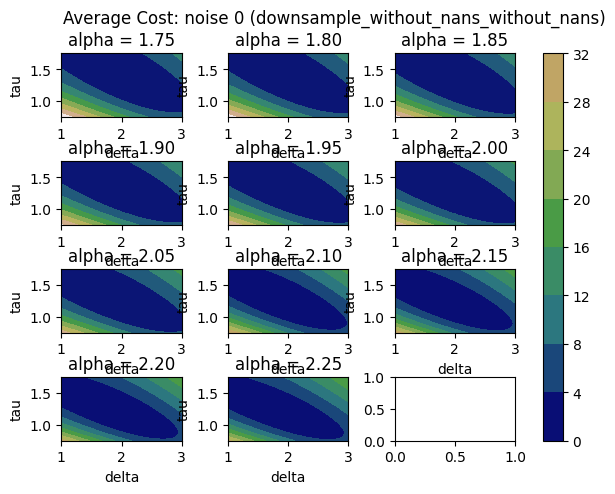

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              38.481149             
2                                              37.549878             
4                                              36.614292             
6                                              35.675284             
8                                              34.733755             
...                                                  ...             
18932                                          16.687466             
18934                                          17.473251             
18936                                          18.253016             
18938                                          19.025675             
18940                                          19.790248             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0    2.0  1.25    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.343441e-03   1.95  1.20   2.15
1      0         0  4.999147e-29   2.00  1.25   2.00
2      0         0  5.365995e-03   2.05  1.30   1.85

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 4.364683224404481e-28; at
      delta   tau  alpha
9471    2.0  1.25    2.0


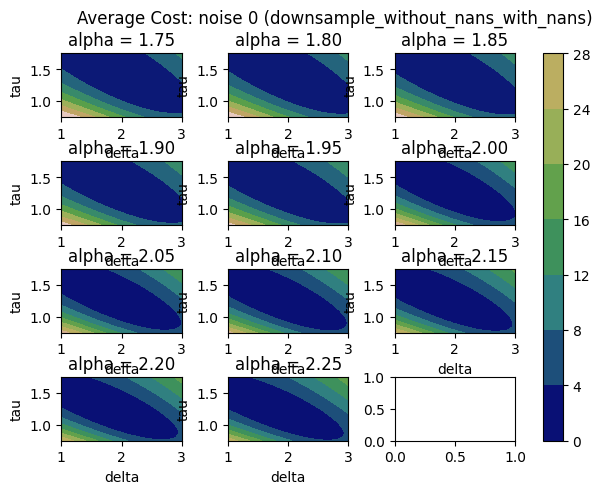

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              35.358382          
3                                              34.543493          
5                                              33.722061          
7                                              32.894869          
9                                              32.062728          
...                                                  ...          
18933                                          15.392164          
18935                                          16.086338          
18937                                          16.772255          
18939                                          17.448968          
18941                                          18.115637          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0    2.0  1.25    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.309716e-03   1.95  1.20   2.15
1      0         0  4.364683e-28   2.00  1.25   2.00
2      0         0  5.462496e-03   2.05  1.30   1.85

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.9970080051823992; at
      delta   tau  alpha
9470    2.0  1.25    2.0


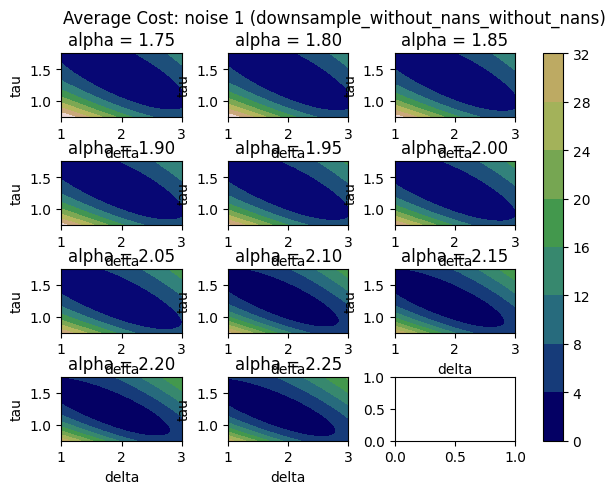

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 3.983874673578133; at
      delta   tau  alpha
9470    2.0  1.25    2.0


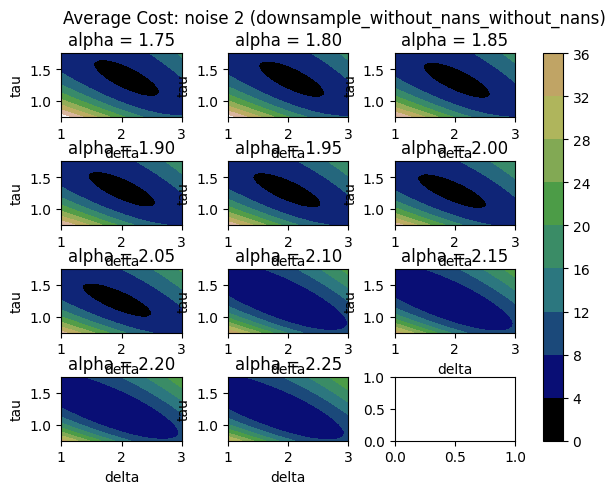

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.976873003838534; at
      delta   tau  alpha
9470    2.0  1.25    2.0


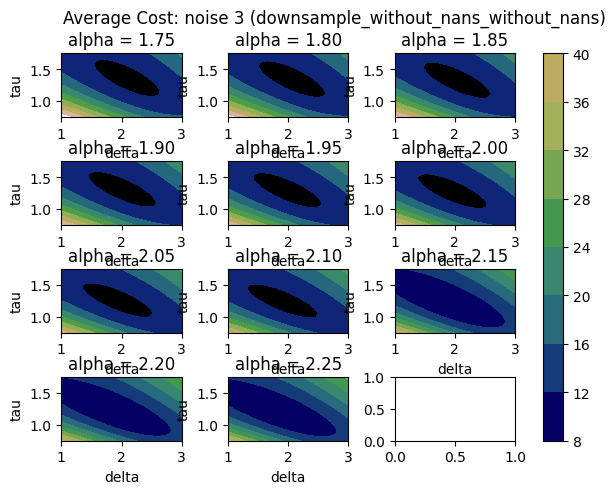

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.936412306080562; at
      delta  tau  alpha
8532    1.9  1.2    2.2


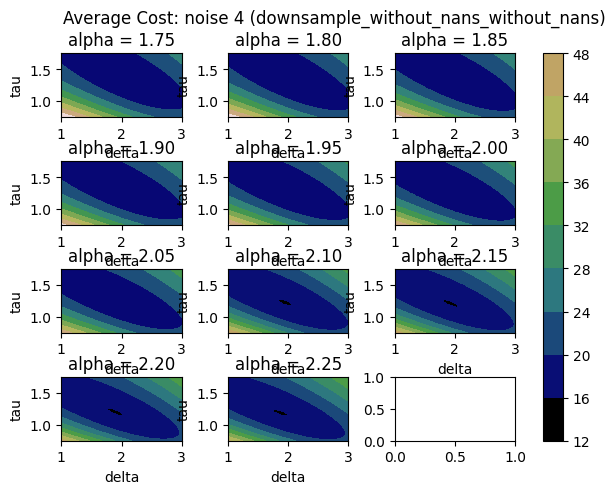

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.023008053045075; at
      delta   tau  alpha
9470    2.0  1.25    2.0


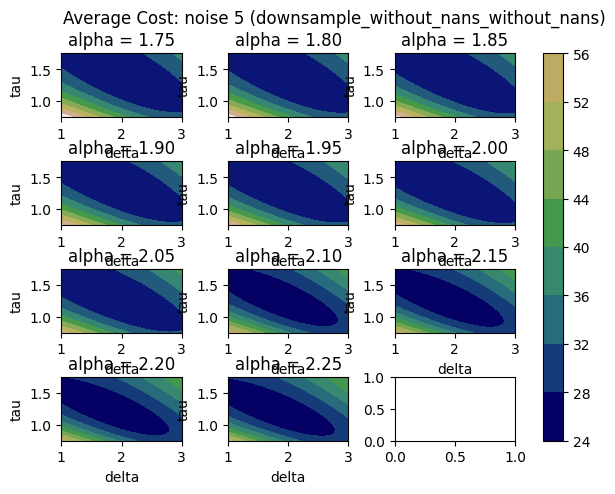

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.054513392514586; at
      delta   tau  alpha
9470    2.0  1.25    2.0


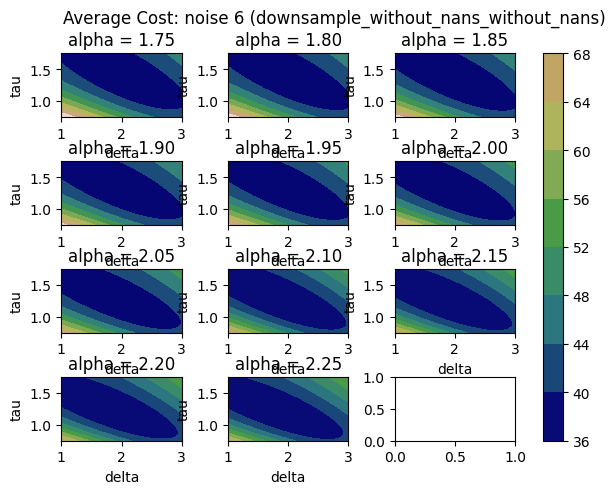

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 49.116955956099154; at
      delta   tau  alpha
9930   2.05  1.25   1.95


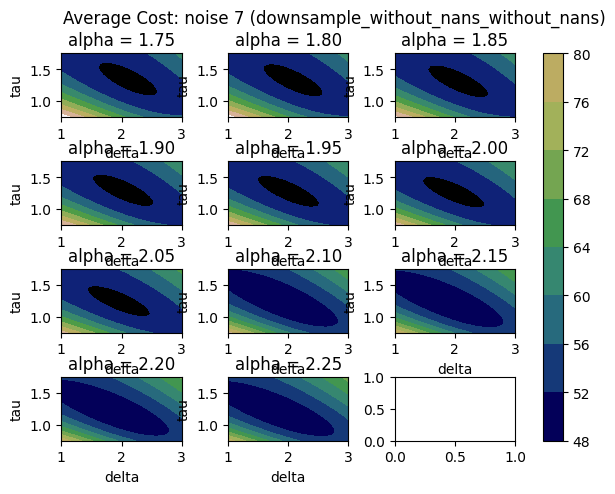

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 63.95541820696026; at
      delta   tau  alpha
9470    2.0  1.25    2.0


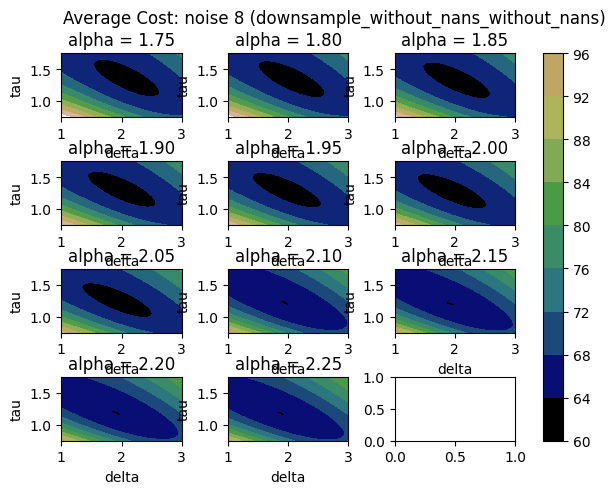

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.26349397467975; at
      delta   tau  alpha
9470    2.0  1.25    2.0


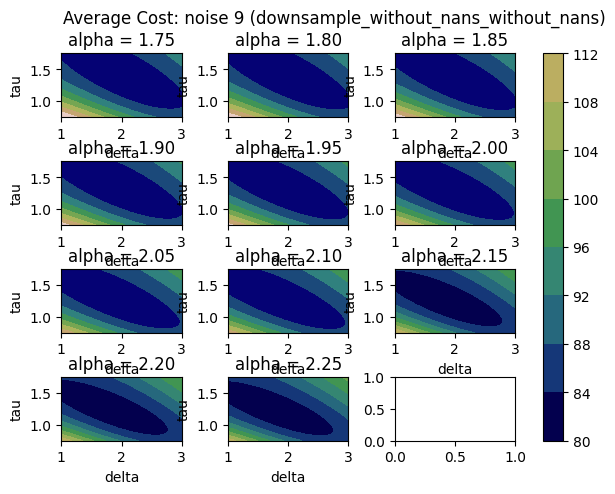

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.94213598391836; at
      delta   tau  alpha
9010   1.95  1.25   2.05


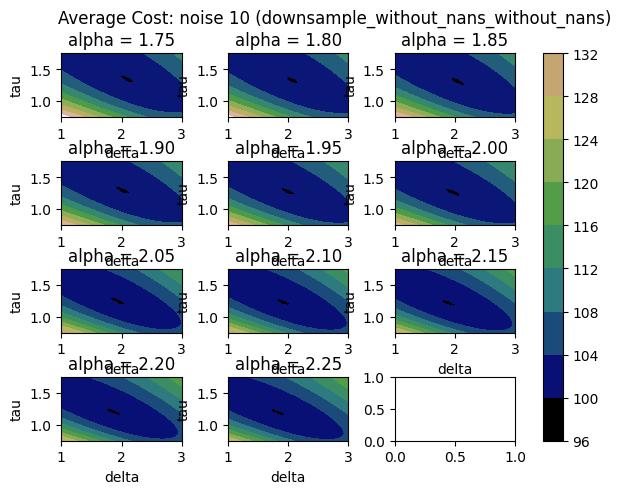

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

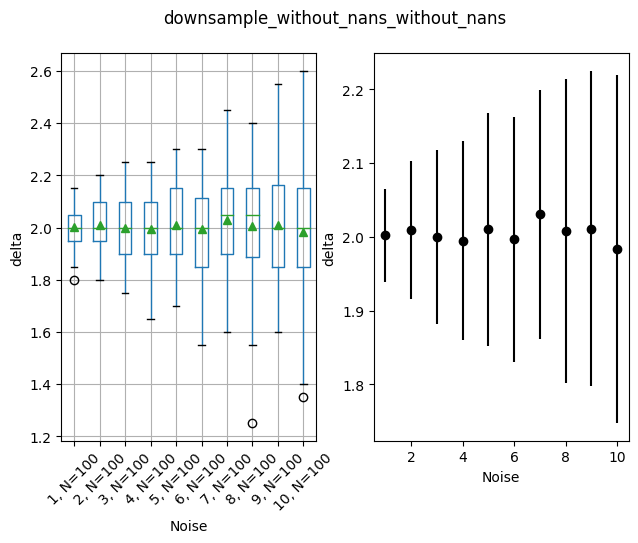

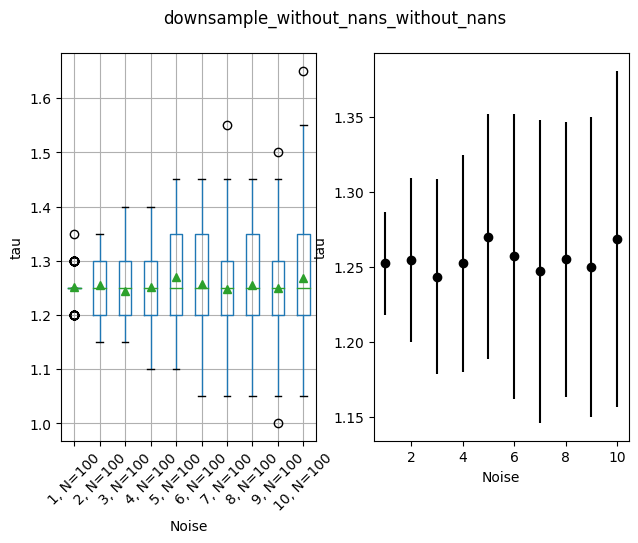

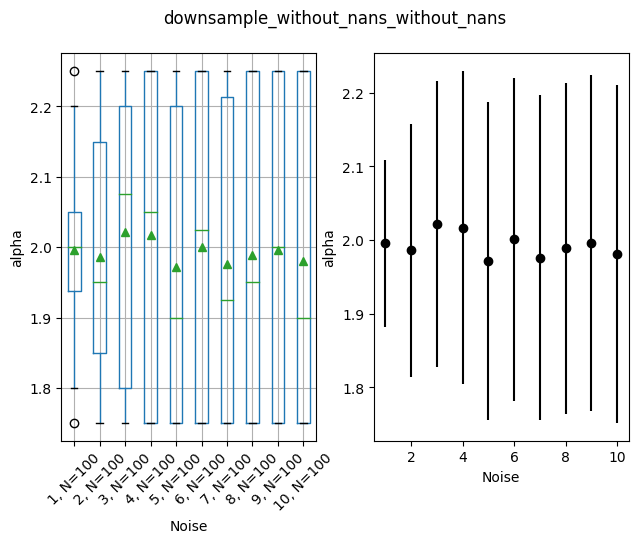

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.000159304929293; at
      delta   tau  alpha
9471    2.0  1.25    2.0


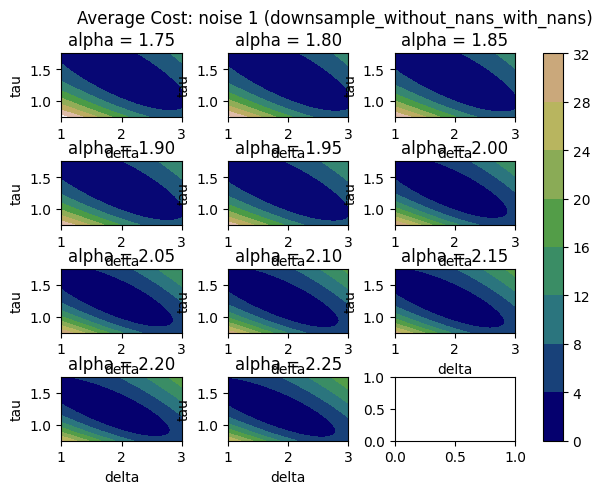

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 3.970390864965775; at
      delta   tau  alpha
9471    2.0  1.25    2.0


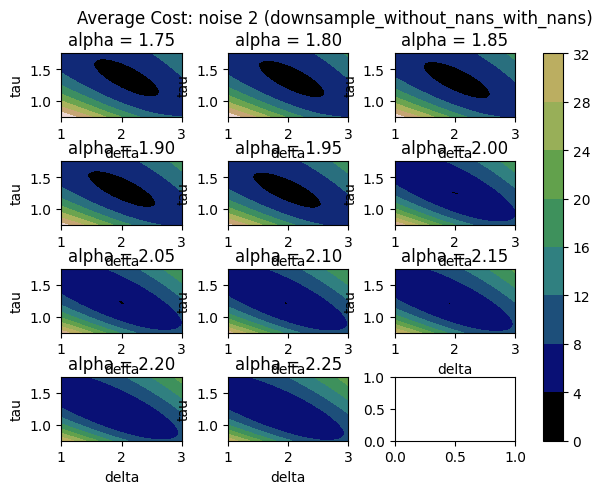

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.971480241999686; at
      delta   tau  alpha
9471    2.0  1.25    2.0


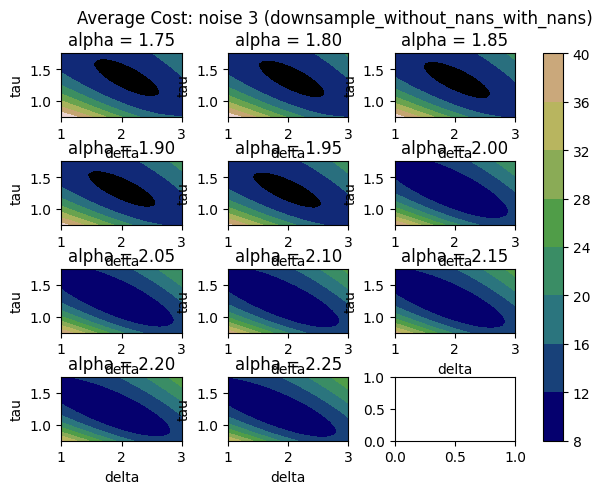

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.931198390541091; at
      delta  tau  alpha
8533    1.9  1.2    2.2


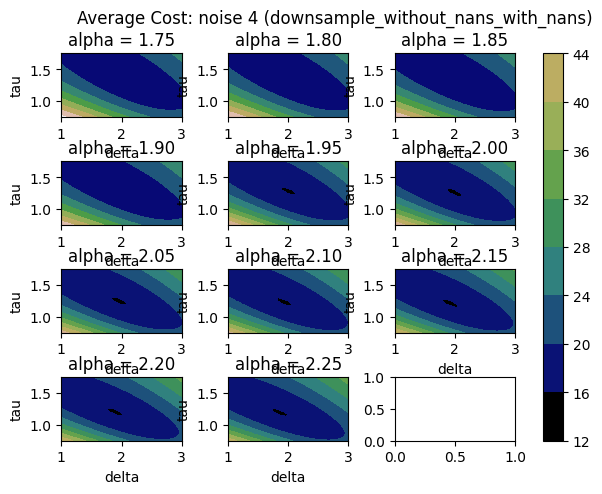

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.08894327248704; at
      delta   tau  alpha
9471    2.0  1.25    2.0


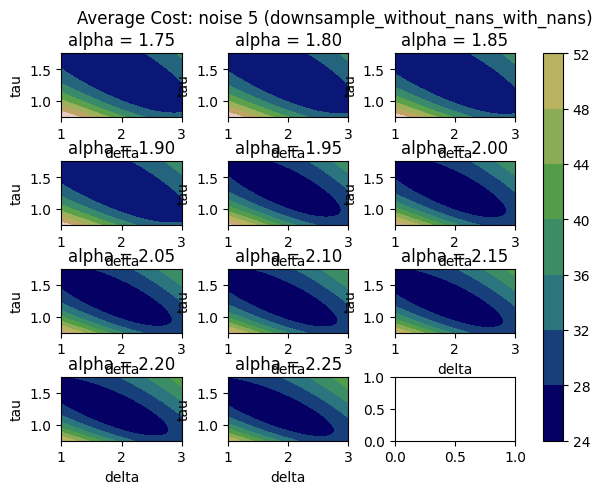

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 35.871376843949335; at
      delta   tau  alpha
9471    2.0  1.25    2.0


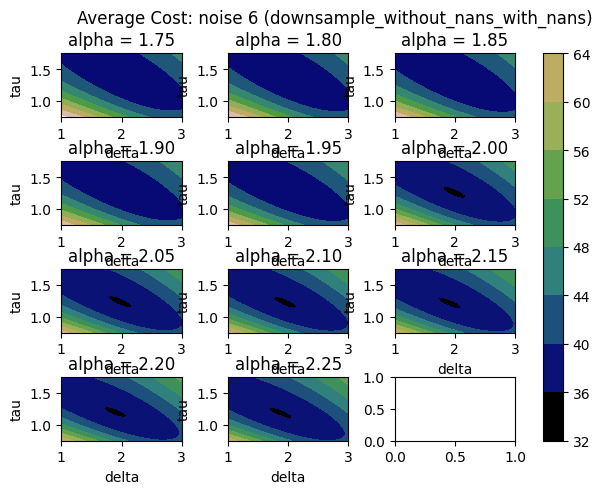

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.99402566622893; at
      delta   tau  alpha
9931   2.05  1.25   1.95


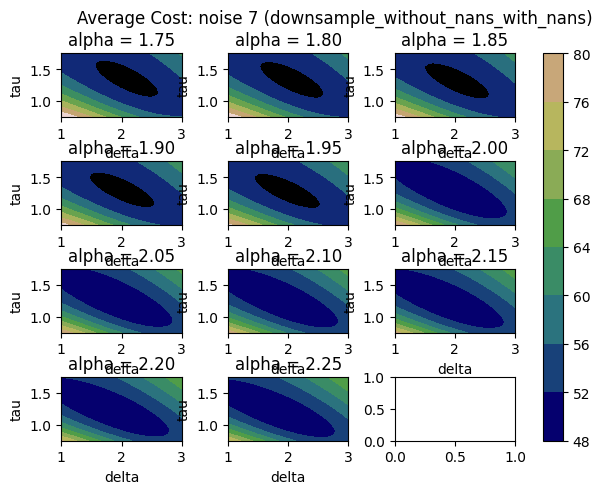

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.14873236385715; at
      delta  tau  alpha
9949   2.05  1.3   1.85


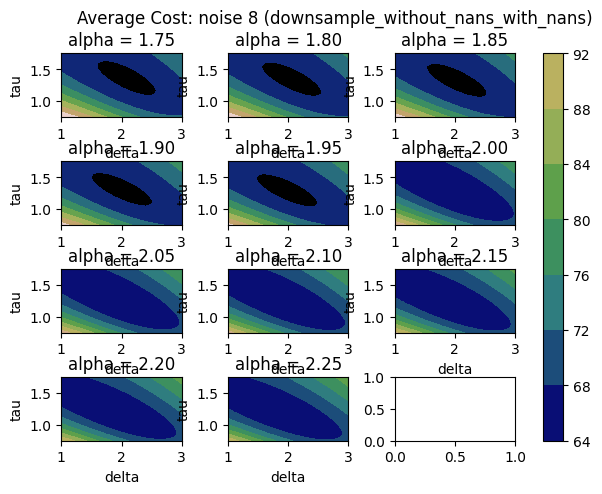

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 80.77334807109865; at
      delta  tau  alpha
8993   1.95  1.2   2.15


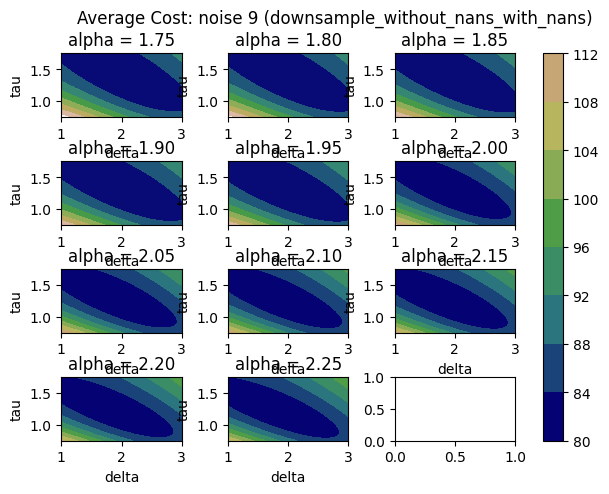

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 100.49795841243598; at
      delta   tau  alpha
9471    2.0  1.25    2.0


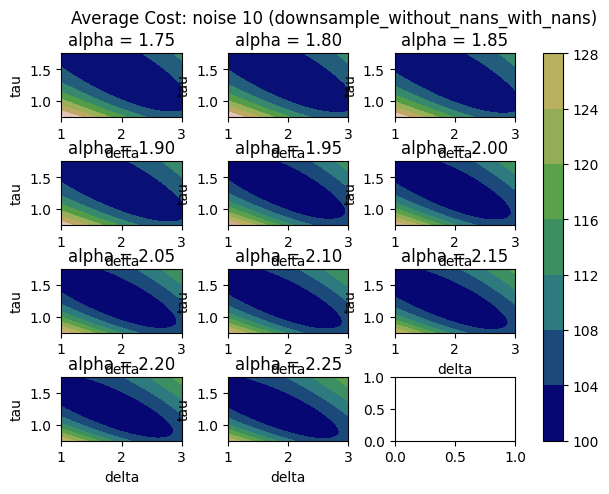

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


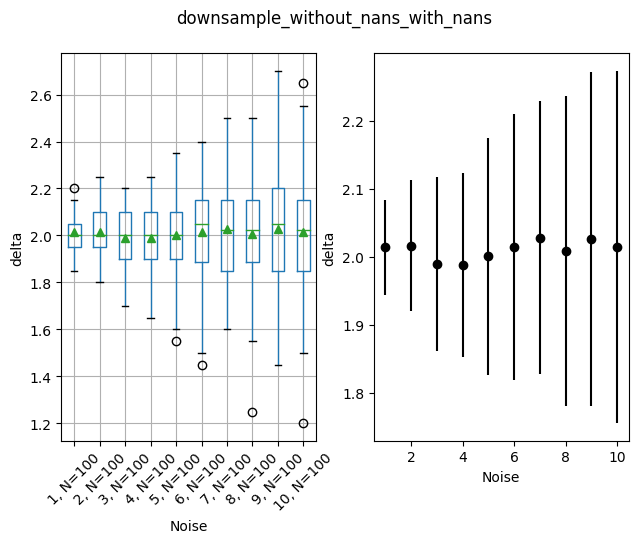

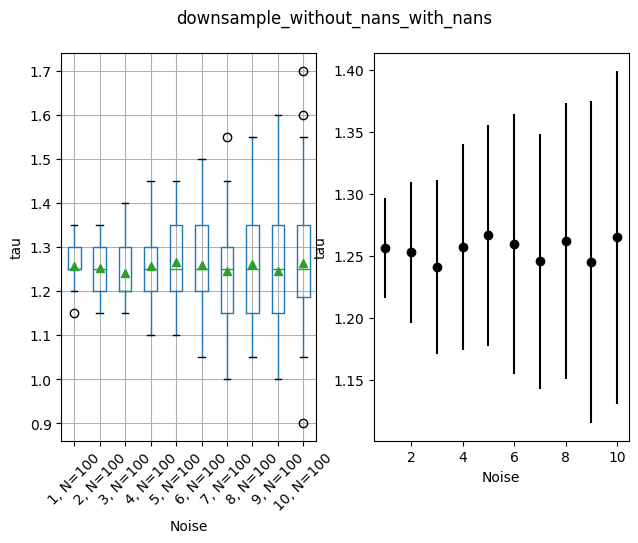

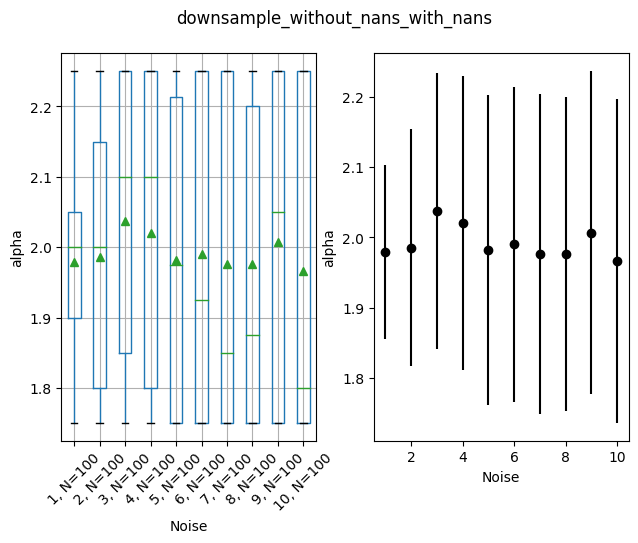

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        42    1.017000  1.8000000000000007  1.2000000000000004   
1         1        49    1.033784  1.8000000000000007  1.2000000000000004   
2         1        13    0.987775  1.8500000000000008  1.2000000000000004   
3         1        55    0.952343  1.8500000000000008  1.2000000000000004   
4         1        61    1.067067  1.8500000000000008  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2672     10         2  102.639375  2.4000000000000012  1.2500000000000004   
2673     10         4  109.822749  2.4000000000000012  1.3000000000000005   
2674     10        70   97.262496  2.4000000000000012  1.3000000000000005   
2675     10        69  107.359264   2.450000000000001  1.2500000000000004   
2676     10        89   98.688780  2.6000000000000014  1.2500000000000004   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2                    2.2  
3                    2.2  
4                    2.2  
...                  ...  
2672                1.75  
2673                1.75  
2674                1.75  
2675                1.75  
2676                1.75  

[2677 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.35  0.538891  2.0  3.0  3.0  4.0  4.0
2                      100.0  3.35  0.575159  2.0  3.0  3.0  4.0  4.0
3                      100.0  3.10  0.858705  1.0  3.0  3.0  4.0  4.0
4                      100.0  2.85  0.891883  1.0  2.0  3.0  3.0  4.0
5                      100.0  2.64  1.087300  1.0  2.0  3.0  4.0  4.0
6                      100.0  2.47  1.039182  1.0  2.0  3.0  3.0  4.0
7                      100.0  2.48  1.086929  1.0  1.0  3.0  3.0  4.0
8                      100.0  2.17  1.073604  1.0  1.0  2.0  3.0  4.0
9                      100.0  2.30  1.114641  1.0  1.0  2.0  3.0  4.0
10                     100.0  2.06  1.161852  1.0  1.0  2.0  3.0  5.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
288       1         1    0.934597   2.100000000000001  1.3500000000000005   
289       1         2    0.926673   2.100000000000001  1.3500000000000005   
290       1         3    0.988786   2.100000000000001  1.3500000000000005   
291       1         5    1.000247   2.100000000000001  1.3500000000000005   
292       1         9    0.985343   2.100000000000001  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2672     10         2  102.639375  2.4000000000000012  1.2500000000000004   
2673     10         4  109.822749  2.4000000000000012  1.3000000000000005   
2674     10        70   97.262496  2.4000000000000012  1.3000000000000005   
2675     10        69  107.359264   2.450000000000001  1.2500000000000004   
2676     10        89   98.688780  2.6000000000000014  1.2500000000000004   

     alpha  
288   1.75  
289   1.75  
290   1.75  
291   1.75  
292   1.75  
...    ...  
2672  1.75  
2673  1.75  
2674  1.75  
2675  1.75  
2676  1.75  

[411 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        35      2   2.100000000000001   33    35      2  1.3500000000000005   
10       51     18   2.100000000000001    7    51      9  1.3000000000000005   
2        32      4   2.100000000000001   18    32      2  1.3500000000000005   
3        29      5  2.1500000000000012   16    29      4  1.3500000000000005   
4        38      8   2.100000000000001   15    38      4  1.3500000000000005   
5        43      9   2.000000000000001    7    43      5  1.3000000000000005   
6        40     10   2.100000000000001    7    40      5  1.3500000000000005   
7        47     13  2.1500000000000012    9    47      8  1.2500000000000004   
8        52     12  2.0500000000000007   12    52      7  1.3500000000000005   
9        44     16   2.200000000000001    6    44      9  1.2500000000000004   

            
      freq  
noise       
1       34  
10      11  
2       20  
3       16  
4       20  
5       16  
6       18  
7       12  
8       14  
9        9

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        42    1.017000  1.8000000000000007  1.2000000000000004   
1         1        49    1.033784  1.8000000000000007  1.2000000000000004   
8         1         3    0.993435  1.8500000000000008  1.2000000000000004   
9         1        41    1.038838  1.8500000000000008  1.2000000000000004   
10        1        78    0.958900  1.8500000000000008  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2613     10         3   99.440683   2.100000000000001  1.2000000000000004   
2626     10        29   98.489487  2.1500000000000012  1.0500000000000003   
2628     10        32  103.217929  2.1500000000000012  1.1000000000000003   
2651     10        37  104.620656   2.250000000000001  1.0500000000000003   
2653     10        58  103.743816   2.250000000000001  1.1000000000000003   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
8     2.2500000000000004  
9     2.2500000000000004  
10    2.2500000000000004  
...                  ...  
2613  2.2500000000000004  
2626  2.2500000000000004  
2628  2.2500000000000004  
2651  2.2500000000000004  
2653  2.2500000000000004  

[415 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1         9      3  1.9500000000000008    4     9      2  1.2000000000000004   
10       50     16  1.9000000000000008    8    50      9  1.2000000000000004   
2        43      4  1.9500000000000008   19    43      2  1.1500000000000004   
3        51      6  1.9500000000000008   14    51      3  1.1500000000000004   
4        43     10  1.9500000000000008   10    43      4  1.2000000000000004   
5        41     10  1.8500000000000008   11    41      4  1.1500000000000004   
6        47     14  1.7500000000000007    8    47      8  1.2000000000000004   
7        39     12  1.8500000000000008    7    39      7  1.1500000000000004   
8        38     14  1.8500000000000008    9    38      8  1.1500000000000004   
9        54     13  1.9000000000000008   11    54      8  1.2000000000000004   

            
      freq  
noise       
1        5  
10      12  
2       24  
3       26  
4       22  
5       17  
6       20  
7       13  
8       17  
9       18

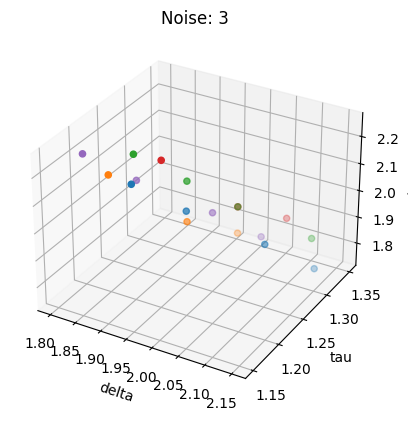

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

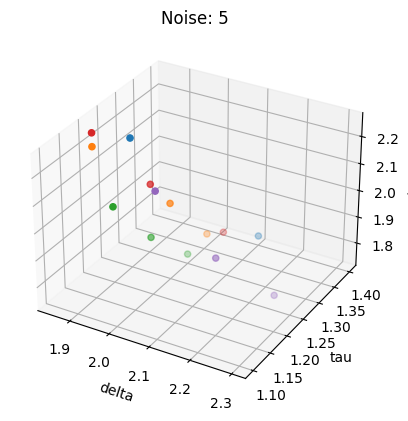

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

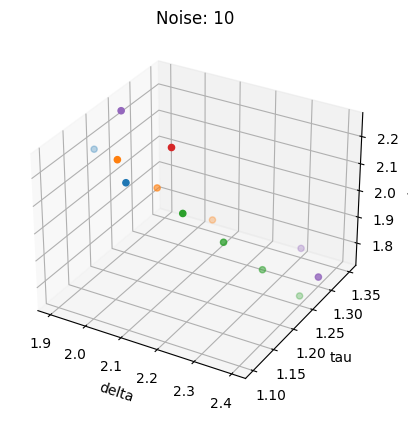

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        42    0.995243  1.8000000000000007  1.2000000000000004   
1         1        76    0.963265  1.8000000000000007  1.2000000000000004   
2         1        13    0.988224  1.8500000000000008  1.2000000000000004   
3         1        41    1.048253  1.8500000000000008  1.2000000000000004   
4         1        49    1.078840  1.8500000000000008  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2561     10         2  102.478086  2.5000000000000013  1.1500000000000004   
2562     10        69  108.399060  2.5000000000000013  1.2000000000000004   
2563     10         3  101.387000  2.5000000000000013  1.2500000000000004   
2564     10        77   97.533538  2.5500000000000016  1.1500000000000004   
2565     10        23  100.529939  2.6500000000000012  1.2500000000000004   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2                    2.2  
3                    2.2  
4                    2.2  
...                  ...  
2561                1.75  
2562                1.75  
2563                1.75  
2564                1.75  
2565                1.75  

[2566 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min   25%  50%  75%  max
noise                                                                 
1                      100.0  3.43  0.590412  2.0  3.00  3.0  4.0  4.0
2                      100.0  3.37  0.705748  1.0  3.00  3.0  4.0  4.0
3                      100.0  2.95  0.946818  1.0  2.75  3.0  4.0  4.0
4                      100.0  2.78  1.106272  1.0  2.00  3.0  4.0  4.0
5                      100.0  2.49  1.105496  1.0  1.00  3.0  3.0  5.0
6                      100.0  2.28  1.206715  1.0  1.00  2.0  3.0  5.0
7                      100.0  2.24  1.173099  1.0  1.00  2.0  3.0  5.0
8                      100.0  2.13  1.252513  1.0  1.00  2.0  3.0  4.0
9                      100.0  1.95  1.076611  1.0  1.00  2.0  3.0  4.0
10                     100.0  2.04  1.213726  1.0  1.00  1.0  3.0  5.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
294       1         2    0.910738   2.100000000000001  1.3500000000000005   
295       1         3    0.948245   2.100000000000001  1.3500000000000005   
296       1         5    1.024261   2.100000000000001  1.3500000000000005   
297       1        10    0.945021   2.100000000000001  1.3500000000000005   
298       1        14    0.958012   2.100000000000001  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2561     10         2  102.478086  2.5000000000000013  1.1500000000000004   
2562     10        69  108.399060  2.5000000000000013  1.2000000000000004   
2563     10         3  101.387000  2.5000000000000013  1.2500000000000004   
2564     10        77   97.533538  2.5500000000000016  1.1500000000000004   
2565     10        23  100.529939  2.6500000000000012  1.2500000000000004   

     alpha  
294   1.75  
295   1.75  
296   1.75  
297   1.75  
298   1.75  
...    ...  
2561  1.75  
2562  1.75  
2563  1.75  
2564  1.75  
2565  1.75  

[422 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        36      3   2.100000000000001   30    36      2  1.3500000000000005   
10       55     19  2.1500000000000012    9    55     13  1.3000000000000005   
2        39      5   2.100000000000001   14    39      2  1.3500000000000005   
3        31      7  2.1500000000000012   10    31      5  1.3000000000000005   
4        34      9   2.100000000000001    9    34      5  1.4000000000000006   
5        45     11   2.250000000000001    9    45      6  1.3500000000000005   
6        44     12   2.100000000000001   10    44      9  1.3500000000000005   
7        46     12  2.1500000000000012    9    46      9  1.2500000000000004   
8        50     13   2.100000000000001    7    50      9  1.4000000000000006   
9        42     17  2.1500000000000012    5    42     11  1.1500000000000004   

            
      freq  
noise       
1       33  
10       9  
2       25  
3       12  
4       13  
5       14  
6       16  
7       12  
8       10  
9        8

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        42    0.995243  1.8000000000000007  1.2000000000000004   
1         1        76    0.963265  1.8000000000000007  1.2000000000000004   
5         1         2    0.924467  1.8500000000000008  1.2000000000000004   
6         1         3    0.949232  1.8500000000000008  1.2000000000000004   
7         1        59    1.083101  1.8500000000000008  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2528     10        65  103.961504   2.250000000000001  1.0000000000000002   
2529     10        37  102.839465   2.250000000000001  1.1000000000000003   
2530     10        58  108.390604   2.250000000000001  1.1000000000000003   
2538     10         3  101.359764   2.300000000000001  1.1000000000000003   
2546     10         2  102.446588  2.3500000000000014  1.0000000000000002   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
5     2.2500000000000004  
6     2.2500000000000004  
7     2.2500000000000004  
...                  ...  
2528  2.2500000000000004  
2529  2.2500000000000004  
2530  2.2500000000000004  
2538  2.2500000000000004  
2546  2.2500000000000004  

[421 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        21      5  1.9500000000000008    8    21      2  1.1500000000000004   
10       50     19  2.0500000000000007    6    50     12  1.1000000000000003   
2        40      5  1.9500000000000008   16    40      2  1.1500000000000004   
3        50      7  1.9500000000000008   12    50      4  1.1500000000000004   
4        48     11  1.9000000000000008   12    48      4  1.2000000000000004   
5        34     12  1.8500000000000008    6    34      5  1.1500000000000004   
6        45     13  1.8000000000000007    9    45      7  1.2000000000000004   
7        44     12  1.8000000000000007    9    44      6  1.2000000000000004   
8        36     14   2.000000000000001    6    36      8  1.1500000000000004   
9        53     16  1.9500000000000008    7    53      9  1.1500000000000004   

            
      freq  
noise       
1       13  
10      10  
2       28  
3       23  
4       20  
5       14  
6       12  
7       13  
8       10  
9       11

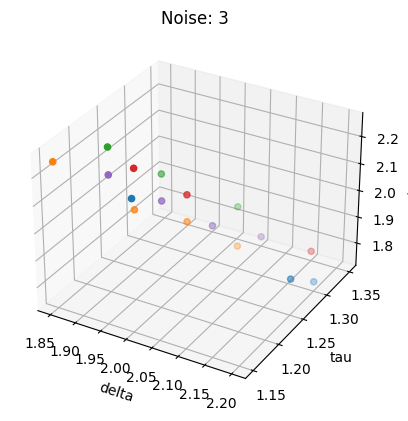

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

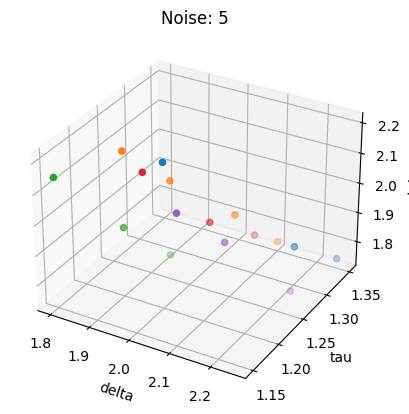

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

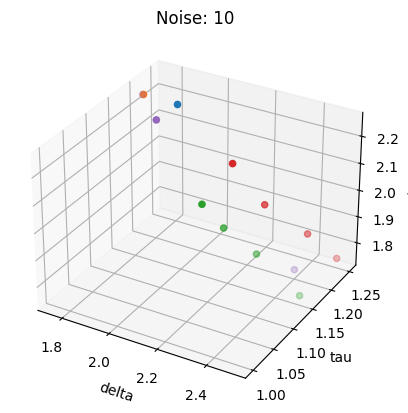

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()